# Install kaggle and then upload json file to import data from the kaggle


In [1]:
!pip install kaggle
from google.colab import files 
files.upload() # upload json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d gakowsher/banglamct7-bangla-multiclass-text-dataset-7-tags

 96% 322M/335M [00:06<00:00, 43.5MB/s]
100% 335M/335M [00:06<00:00, 51.5MB/s]


In [3]:
from zipfile import ZipFile
file_name= "banglamct7-bangla-multiclass-text-dataset-7-tags.zip"

with ZipFile(file_name ,'r') as zip:
  zip.extractall()
  print('Done')

Done


# Import Libraries


In [24]:
import pandas as pd
import numpy as np
import os
from google.colab import output


In [25]:
import re
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D

from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical


from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
!pip install bangla-stemmer


import seaborn as sns
import matplotlib.pyplot as plt
output.clear()

#Read Dataset

In [26]:
train_data=pd.read_csv('/content/BanglaMCT7/train.csv')
test_data = pd.read_csv('/content/BanglaMCT7/test.csv')

In [27]:
train_data.head()

,category,text,cleanText
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...


In [28]:
train_data.text.iloc[5]

'খুদে ব্লগ লেখার জনপ্রিয় সাইট টুইটার এখন বাংলা ভাষায় দেখা যাবে। টুইটারের মূল ওয়েবসাইটের পাশাপাশি মোবাইল ওয়েবসাইট(mobile.twitter.com), অ্যান্ড্রয়েড ও আইওএস অ্যাপ্লিকেশনে (অ্যাপ) বাংলা সমর্থনের সুবিধা চালু করেছে। এর ফলে সম্পূর্ণ বাংলায় বার্তা (টুইট) লেখা ও পড়া যাবে। বাংলা ছাড়াও সম্প্রতি ভিয়েতনামিস, চেক, রোমানিয়ান ও ইউক্রেনিয়ান ভাষা যুক্ত হয়েছে টুইটারে। বিভিন্ন ভাষাভাষীর স্বেচ্ছাসেবকদের অনুবাদ করা এসব ভাষা এর আগে শুধু অনুবাদকাজের সঙ্গে যুক্ত স্বেচ্ছাসেবকদের জন্য উন্মুক্ত ছিল।গতকাল মঙ্গলবার থেকে এসব ভাষার সুবিধা সাধারণ ব্যবহারকারীদের জন্য উন্মুক্ত করা হয়েছে। বাংলা কিংবা অন্যান্য ভাষা নির্বাচন করতে টুইটারের সেটিংস থেকে ভাষা অপশনে গিয়ে পছন্দের ভাষা বেছে নিতে হবে।চাইলে যে কেউ টুইটারের এ ভাষা অনুবাদেও যুক্ত হতে পারেন। এতে নির্দিষ্ট শব্দ কিংবা লাইনের সঠিক অর্থ লিখে জমা দেওয়া যাবে। সেখান থেকে নির্বাচিত এবং সঞ্চালক কর্তৃক পরীক্ষিত হওয়ার পর সেটি মূল টুইটারে বাংলা ভাষায় যুক্ত হবে। আগ্রহীরা (translate.twitter.com) ঠিকানায় গিয়ে বাংলা অনুবাদে যুক্ত হতে পারেন।উল্লেখ্য, ২০০৬ সালে মাত্র ১৪০ শব্দের মধ্

In [29]:
train_data.cleanText.iloc[5]

'  খুদে    ব্লগ    লেখার    জনপ্রিয়    সাইট    টুইটার    বাংলা    ভাষায়    টুইটারের    মূল    ওয়েবসাইটের    পাশাপাশি    মোবাইল    ওয়েবসাইট    অ্যান্ড্রয়েড    আইওএস    অ্যাপ্লিকেশনে    অ্যাপ    বাংলা    সমর্থনের    সুবিধা    চালু    সম্পূর্ণ    বাংলায়    বার্তা    টুইট    লেখা    পড়া    বাংলা    ছাড়াও    ভিয়েতনামিস    চেক    রোমানিয়ান    ইউক্রেনিয়ান    ভাষা    যুক্ত    টুইটারে    বিভিন্ন    ভাষাভাষীর    স্বেচ্ছাসেবকদের    অনুবাদ    এসব    ভাষা    অনুবাদকাজের    যুক্ত    স্বেচ্ছাসেবকদের    উন্মুক্ত    গতকাল    মঙ্গলবার    এসব    ভাষার    সুবিধা    সাধারণ    ব্যবহারকারীদের    উন্মুক্ত    বাংলা    অন্যান্য    ভাষা    নির্বাচন    টুইটারের    সেটিংস    ভাষা    অপশনে    পছন্দের    ভাষা    বেছে    চাইলে    টুইটারের    ভাষা    অনুবাদেও    যুক্ত    নির্দিষ্ট    শব্দ    লাইনের    সঠিক    অর্থ    লিখে    জমা    নির্বাচিত    সঞ্চালক    কর্তৃক    পরীক্ষিত    মূল    টুইটারে    বাংলা    ভাষায়    যুক্ত    আগ্রহীরা    ঠিকানায়    বাংলা    অনুবাদে    যুক্ত    উল্লেখ্য    সালে    শব্দের    খুদে    ব্লগ 

In [30]:
test_data.head()

,category,text,cleanText
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...


In [31]:
train_data

,category,text,cleanText
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...
...,...,...,...
98878,education,সহকারী অধ্যাপক টিচার্স ট্রেনিং কলেজ (মহিলা)...,সহকারী অধ্যাপক টিচার্স ট্রেনিং ক...
98879,entertainment,অক্টোবরের ১১ তারিখে ৭৫ বছর পূর্ণ করবেন অমিতাভ ...,অক্টোবরের তারিখে বছর পূর্ণ অমিতা...
98880,technology,কাজী নাঈম আল রশিদ। সফটওয়্যার প্রকৌশলী। কাজ করে...,কাজী নাঈম রশিদ সফটওয়্যার প্রকৌশল...
98881,technology,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ভেরাইজন কিনে...,ইয়াহুকে মার্কিন টেলিকম প্রতিষ্ঠান ...


In [32]:
test_data

,category,text,cleanText
0,education,"অধ্যায়-২প্রিয় পরীক্ষার্থী, আজ তথ্য ও যোগাযোগ প...",অধ্যায় প্রিয় পরীক্ষার্থী তথ্য যো...
1,sports,"স্পিন, স্পিন, স্পিন। লর্ডসে ইয়াসির শাহ্‌র লেগ ...",স্পিন স্পিন স্পিন লর্ডসে ইয়াসির ...
2,international,সিরিয়ার উত্তর-পশ্চিমাঞ্চলে গতকাল রোববার বিমান...,সিরিয়ার উত্তর পশ্চিমাঞ্চলে গতকাল ...
3,international,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যালয়ের (ইউসিট...,দক্ষিণ আফ্রিকার কেপটাউন বিশ্ববিদ্যা...
4,technology,সহজে ডিজিটাল আর্থিক সেবা দিতে অ্যাপ ও ডিজিটাল ...,সহজে ডিজিটাল আর্থিক সেবা অ্যাপ ...
...,...,...,...
98879,sports,১৯৫৯ সালে ইউরোপিয়ান ক্লাব কাপে জাতীয় দল পাঠান...,সালে ইউরোপিয়ান ক্লাব কাপে জাতীয়...
98880,entertainment,গানের দল সহজিয়ার প্রথম অ্যালবাম ‘রঙমিস্ত্রী’র ...,গানের সহজিয়ার প্রথম অ্যালবাম রঙম...
98881,international,ফেসবুকের ৮১ হাজার ব্যবহারকারীর তথ্য চুরি করে স...,ফেসবুকের হাজার ব্যবহারকারীর তথ্য ...
98882,economy,পেট্রোল পাম্পে তেল বা সিএনজির বিল বিকাশের মাধ...,পেট্রোল পাম্পে তেল সিএনজির বিল ...


#Train Data Info

In [33]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98883 entries, 0 to 98882
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98883 non-null  object
 1   text       98883 non-null  object
 2   cleanText  98883 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


#Test Data Info

In [34]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98884 entries, 0 to 98883
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   98884 non-null  object
 1   text       98884 non-null  object
 2   cleanText  98884 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


#Value Count per Category in Train and Test dataset

In [35]:
train_data.category.value_counts()

sports           15672
international    15540
state            15362
entertainment    15198
economy          14430
education        12674
technology       10007
Name: category, dtype: int64

In [36]:
test_data.category.value_counts()

sports           15883
international    15314
entertainment    15261
state            15183
economy          14488
education        12818
technology        9937
Name: category, dtype: int64

# NaN or Null Value Check

In [37]:
print(train_data.isna().sum())

category     0
text         0
cleanText    0
dtype: int64


In [38]:
print(test_data.isna().sum())

category     0
text         0
cleanText    0
dtype: int64


In [39]:
train_data['category'].unique()

array(['economy', 'sports', 'international', 'state', 'technology',
       'entertainment', 'education'], dtype=object)

#Countplot of Category Value in Train and Test dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'economy'),
 Text(0, 0, 'sports'),
 Text(0, 0, 'international'),
 Text(0, 0, 'state'),
 Text(0, 0, 'technology'),
 Text(0, 0, 'entertainment'),
 Text(0, 0, 'education')]

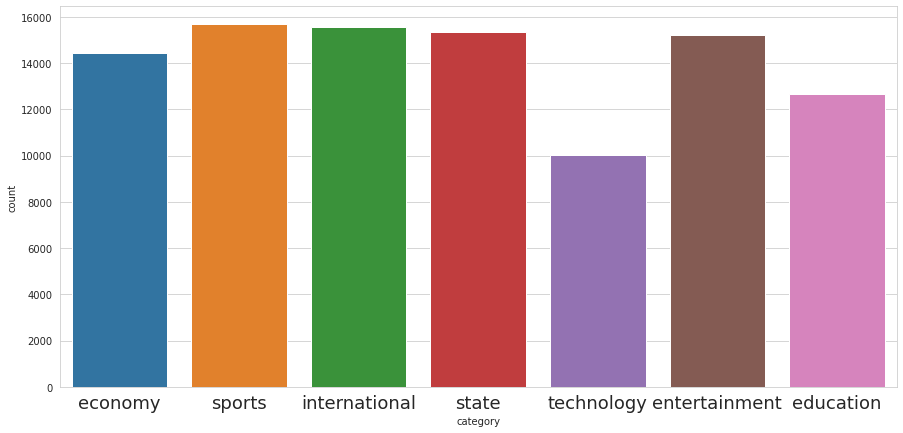

In [40]:
lst=['economy', 'sports', 'international', 'state', 'technology',
       'entertainment', 'education']
sns.set_style('whitegrid')
countplt, ax = plt.subplots(figsize = (15,7))
ax=sns.countplot(train_data['category'],order=lst)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=18)



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'economy'),
 Text(0, 0, 'sports'),
 Text(0, 0, 'international'),
 Text(0, 0, 'state'),
 Text(0, 0, 'technology'),
 Text(0, 0, 'entertainment'),
 Text(0, 0, 'education')]

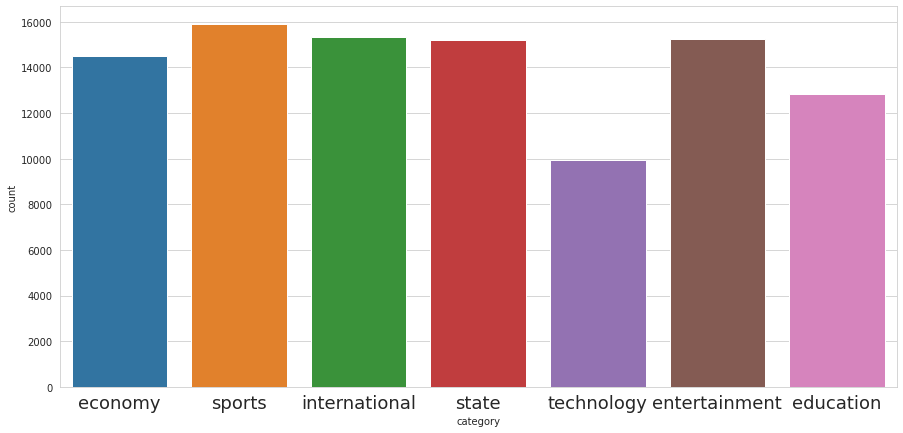

In [41]:
sns.set_style('whitegrid')
countplt, ax = plt.subplots(figsize = (15,7))
ax=sns.countplot(test_data['category'],order=lst)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=18)



#Count Word Length in a Text data in Train and Test dataset

In [42]:
def count_word(a):
  word_lst= a.split()
  number_of_words=len(word_lst)
  return number_of_words

train_data['length']=train_data['cleanText'].apply(count_word)
train_data.head()

,category,text,cleanText,length
0,economy,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সংস্থা (ডব্লিউট...,বাংলাদেশে সফররত বিশ্ব বাণিজ্য সং...,293
1,sports,ইউরোপিয়ান ফুটবলে আজ ঝড় বয়ে যাচ্ছে। একদিকে সংবা...,ইউরোপিয়ান ফুটবলে বয়ে একদিকে সংবা...,206
2,international,বিজেপির নেতৃত্বে ভারতের উত্তর প্রদেশ থেকে শুরু...,বিজেপির নেতৃত্বে ভারতের উত্তর প্...,167
3,state,নারায়ণগঞ্জের সোনারগাঁ উপজেলার একটি সরকারি প্র...,নারায়ণগঞ্জের সোনারগাঁ উপজেলার সরকা...,181
4,sports,"‘ছাই থেকে ছাই, ধুলো থেকে ধুলো...’ আধ্যাত্মিক ক...",ছাই ছাই ধুলো ধুলো আধ্যাত্মিক ...,148


#Max and Min Word length in Train Dataset

In [43]:
train_data['length'].max()

5243

In [44]:
train_data['length'].min()

1

In [45]:
xx=train_data[train_data['length']==1]
xx

,category,text,cleanText,length
6584,education,বাগধারা,বাগধারা,1
47443,economy,মাথাপিছু আয়,মাথাপিছু,1
53230,economy,বিনিয়োগ,বিনিয়োগ,1
66243,education,রচনামূলক,রচনামূলক,1
94158,education,গদ্যাংশ,গদ্যাংশ,1
97424,education,বহুনির্বাচনী,বহুনির্বাচনী,1


#Max and Min Word length in Test Dataset

In [46]:
test_data['length']=test_data['cleanText'].apply(count_word)
print(test_data['length'].max())

5754


In [47]:
print(test_data['length'].min())

1


In [48]:
xx=test_data[test_data['length']==1]
xx

,category,text,cleanText,length
24653,education," ইংরেজিTime : 2 hour 30 Minutes, Full Marks :...",ইংরেজি,1
64413,education,বাংলা,বাংলা,1
73989,education,পদার্থবিজ্ঞান,পদার্থবিজ্ঞান,1


#Histrogram of words length in Train and Test dataset

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'word length')

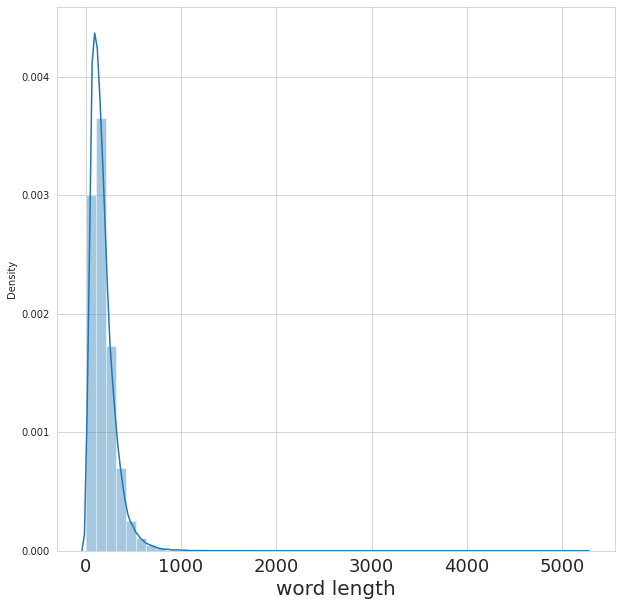

In [49]:
#histogram
plt.figure(figsize=(10,10))
plt.rc('xtick',labelsize=18)
sns.distplot(train_data['length'])
plt.xlabel('word length', fontsize=20)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'word length')

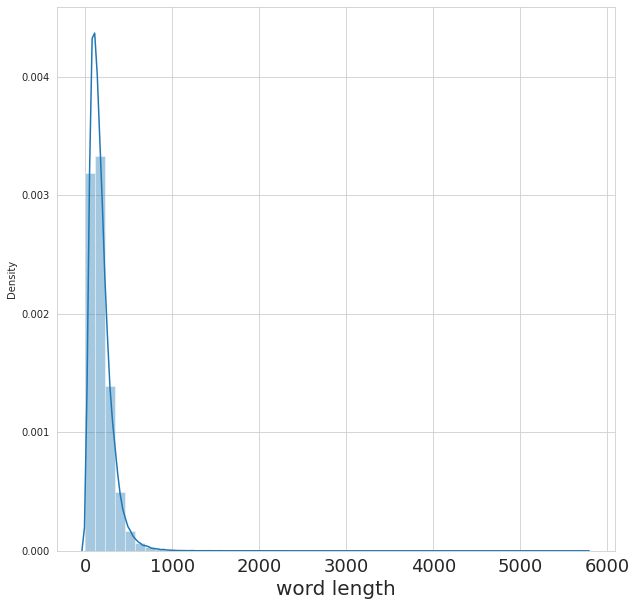

In [50]:
#histogram
plt.figure(figsize=(10,10))
plt.rc('xtick',labelsize=18)
sns.distplot(test_data['length'])
plt.xlabel('word length', fontsize=20)

#Scatter Plot of per Categrory Vs word length of a text data in Train and Test Dataset

Text(0, 0.5, 'length')

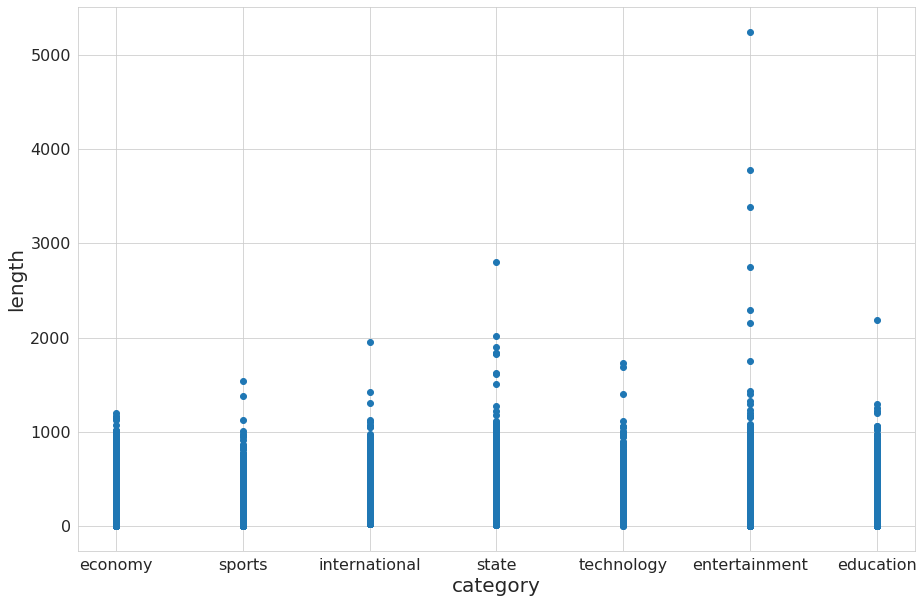

In [51]:
#scatter plot grlivarea/saleprice
plt.figure(figsize=(15,10))
plt.rc('xtick',labelsize=16, )
plt.rc('ytick',labelsize=16)
plt.scatter(x=train_data['category'], y=train_data['length'] )
plt.xlabel('category', fontsize=20  )
plt.ylabel('length', fontsize=20  )

Text(0, 0.5, 'length')

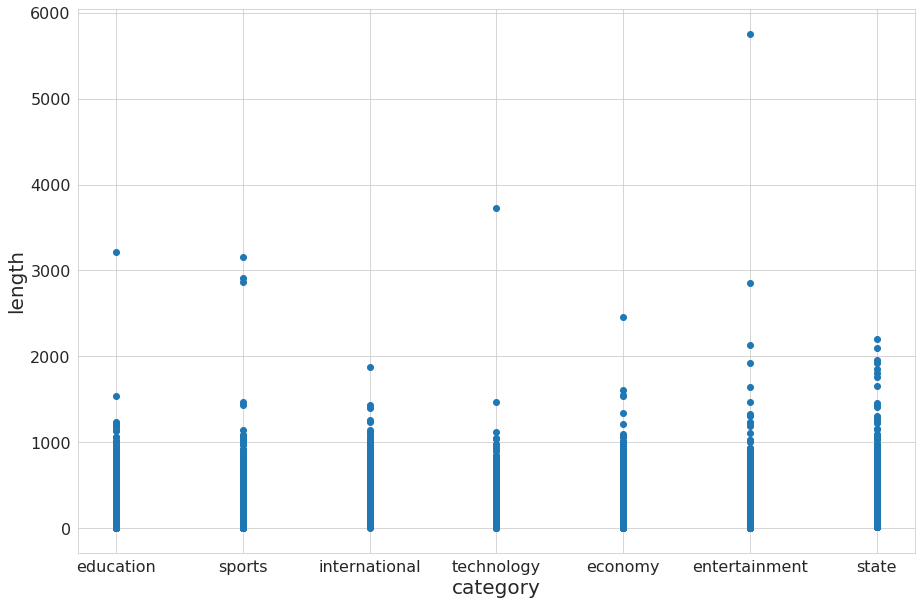

In [52]:
#scatter plot grlivarea/saleprice
plt.figure(figsize=(15,10))
plt.rc('xtick',labelsize=16, )
plt.rc('ytick',labelsize=16)
plt.scatter(x=test_data['category'], y=test_data['length'] )
plt.xlabel('category', fontsize=20  )
plt.ylabel('length', fontsize=20  )

#Total Number of Unique Sentence in Train Dataset

In [53]:
from collections import Counter
result = len(set(Counter(" ".join(train_data['cleanText'].values.tolist()).split(" ")).items()))
result

464249

#Total Number of Unique Sentence in Test Dataset

In [54]:
result2 = len(set(Counter(" ".join(test_data['cleanText'].values.tolist()).split(" ")).items()))
result2

463897